In [1]:
using Revise

In [2]:
import PyCall

import OccGrid as O
import PointCloud as PC

# If undefined: (@v1.6) pkg> dev PointCloud
import PointCloud: CameraIntrinsics

import Control: BeliefState, execute_command!
import PoseComposition: Pose, IDENTITY_POSE, IDENTITY_ORN
using StaticArrays

global MCS = PyCall.pyimport("machine_common_sense")
global np = PyCall.pyimport("numpy")

┌ Info: Precompiling OccGrid [edab0b8f-8780-4496-95e4-2972e6434f91]
└ @ Base loading.jl:1342
┌ Info: Precompiling PointCloud [febe334d-ce8c-46bf-a83a-c33eb062e54c]
└ @ Base loading.jl:1342


PyObject <module 'numpy' from '/usr/local/lib/python3.8/dist-packages/numpy/__init__.py'>

In [3]:
import Pkg; Pkg.status()

     Project InverseGraphics v0.1.0
      Status `/cora/InverseGraphics/Project.toml`
  [aaaa29a8] Clustering v0.14.2
  [35d6a980] ColorSchemes v3.17.1
  [5ae59095] Colors v0.12.8
  [150eb455] CoordinateTransformations v0.6.2
  [864edb3b] DataStructures v0.18.11
  [b4f34e82] Distances v0.10.7
  [31c24e10] Distributions v0.25.52
  [b7d42ee7] Einsum v0.4.1
  [5789e2e9] FileIO v1.13.0
  [f7f18e0c] GLFW v3.4.1
  [d1e26eb4] GLRenderer v0.1.4
  [ea4f424c] Gen v0.4.4
  [85d806fb] GenDirectionalStats v0.1.1
  [5c1252a2] GeometryBasics v0.3.13
  [7073ff75] IJulia v1.23.2
  [916415d5] Images v0.24.1
  [682c06a0] JSON v0.21.3
  [093fc24a] LightGraphs v1.3.5
  [23992714] MAT v0.10.3
  [442fdcdd] Measures v0.3.1
  [c03570c3] Memoize v0.4.4
  [3bb1c1c2] MeshCatViz v0.1.0
  [7269a6da] MeshIO v0.4.7
  [626554b9] MetaGraphs v0.6.8
  [888bd7f2] MiniGSG v0.1.0
  [66fc600b] ModernGL v1.1.4
  [b8a86587] NearestNeighbors v0.4.9
  [d96e819e] Parameters v0.12.3
  [54e51dfa] PerceptualColourMaps v0.3.5
  [91a5

In [4]:
cora_path = get(ENV, "CORA_PATH", "/cora")
cora_agent_path = joinpath(cora_path, "cora-agent")
scene_path = joinpath(cora_agent_path, "test/data/eval5/ball_behind_sofa.json")
config_path = joinpath(cora_agent_path, "test/data/config_level2.ini")

if "MCS_CONFIG_FILE_PATH" ∈ keys(ENV)
    println("\nWARNING: MCS_CONFIG_FILE_PATH is set and might interfere with your defined information level.")
end

if isfile(config_path)
    controller = MCS.create_controller(config_file_or_dict=config_path)
else
    println("Error: Config file path \"$(config_path)\" does not exist.")
end

if isfile(scene_path)
    scene_config = MCS.load_scene_json_file(scene_path);
else
    println("Error: Scene path \"$(scene_path)\" does not exist.")
end

Found path: /root/.mcs/0.5.2/MCS-AI2-THOR-Unity-App-v0.5.2.x86_64


Dict{Any, Any} with 8 entries:
  "performerStart"  => Dict{Any, Any}("rotation"=>Dict{Any, Any}("x"=>0, "y"=>0…
  "name"            => "soccer_ball_retrieval_example"
  "floorMaterial"   => "AI2-THOR/Materials/Fabrics/CarpetWhite 3"
  "ceilingMaterial" => "AI2-THOR/Materials/Walls/Drywall"
  "objects"         => Dict{Any, Any}[Dict("salientMaterials"=>["fabric"], "mat…
  "wallMaterial"    => "AI2-THOR/Materials/Walls/DrywallBeige"
  "goal"            => Dict{Any, Any}("metadata"=>Dict{Any, Any}("target"=>Dict…
  "version"         => 2

In [5]:
step_metadata = controller.start_scene(scene_config)

PyObject <machine_common_sense.step_metadata.StepMetadata object at 0x7ffabf34c580>

In [6]:
intrinsics = CameraIntrinsics(step_metadata)

Geometry.CameraIntrinsics
  width: Int64 600
  height: Int64 400
  fx: Float64 514.2991467983065
  fy: Float64 514.2991467983065
  cx: Float64 300.0
  cy: Float64 200.0
  near: Float64 9.999999747378752e-5
  far: Float64 9999.0


In [7]:
belief_state = BeliefState(
    intrinsics=intrinsics,
    step_metadata_history=[step_metadata],
    action_history=[],
    pose_history=[IDENTITY_POSE],
    information_level="level2",
    time_to_live=0
);

# obs = [step_metadata] ∪ [execute_command!(controller, belief_state, "RotateRight") for _  in 1:35];
for _  in 1:35
    execute_command!(controller, belief_state, "RotateRight")
end

In [8]:
PC.realign_world!(belief_state)

In [9]:
occupancy_grid_config = O.OccupancyGridConfig(SVector{3, Float64}([0.3, 0.3, 0.3]))
occupancy_grid = O.OccupancyGrid(occupancy_grid_config)

OccGrid.OccupancyGrid(OccGrid.OccupancyGridConfig([0.3, 0.3, 0.3], 1), Dict{SVector{3, Int64}, Int64}(), Dict{SVector{3, Int64}, Int64}(), [0, 0, 0], [0, 0, 0], [0, 0, 0])

In [10]:
objects_only_cloud, world_bbox, perception_updated_until = PC.perception_initializiation(belief_state, occupancy_grid, 1, length(belief_state.pose_history));

## Render Naively
The following will render the `objects_only_cloud` just extracted.

In [ ]:
try
    import MeshCatViz as V
catch
    import MeshCatViz as V    
end
V.setup_visualizer()

In [ ]:
import Images as I

V.viz(objects_only_cloud[1:3, :] ./ 5.0; color=I.colorant"black", channel_name=:gen_cloud)

## Compute Mesh

In [16]:
resolution = 0.1  # 0.05

# import SceneGenerativeModel as SGM
# Note: occupancy_grid_config.grid_resolution is vector of length 3, but function needs single value
# mesh = SGM.cloud_to_mesh(objects_only_cloud[1:3, :], resolution)

import GLRenderer as GL

# TODO function occupancy_grid_to_mesh(occupancy_grid)
voxel_grid = GL.voxelize(objects_only_cloud[1:3, :], resolution)
mesh = GL.mesh_from_voxelized_cloud(voxel_grid, resolution)

GLRenderer.Mesh
  vertices: Array{Float64}((3, 328560)) [4.65 4.75 … -2.55 -2.45; 0.65 0.65 … -1.45 -1.45; -2.2500000000000004 -2.2500000000000004 … 4.95 4.95]
  indices: Array{Int64}((3, 164280)) [0 1 … 328556 328557; 2 2 … 328558 328558; 1 3 … 328557 328559]
  normals: Array{Float64}((3, 328560)) [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 1.0 1.0; 1.0 1.0 … 0.0 0.0]
  tex_coords: Nothing nothing
  tex_path: Nothing nothing


In [17]:
import InverseGraphics as T

IDX = 1000
YCB_DIR = joinpath(dirname(pwd()),"data")
world_scaling_factor = 10.0
id_to_cloud, id_to_shift, id_to_box  = T.load_ycbv_models_adjusted(YCB_DIR, world_scaling_factor);
# all_ids = sort(collect(keys(id_to_cloud)));
# names = T.load_ycb_model_list(YCB_DIR)

gt_poses, ids, gt_rgb_image, gt_depth_image, cam_pose, original_camera = T.load_ycbv_scene_adjusted(
    YCB_DIR, IDX, world_scaling_factor, id_to_shift
);

In [52]:
import PoseComposition: Pose, IDENTITY_POSE, IDENTITY_ORN, QuatRotation

In [54]:
pose = Pose([0.7400052114043696, 0.8726610699919363, 8.712766016937628], QuatRotation(0.43682484719575687, 0.7508444627918284, 0.47275777555610393, -0.14804300462534098))

Pose⟨pos=[0.7400052114043696, 0.8726610699919363, 8.712766016937628], orientation=(w=0.436824847195757, x=0.7508444627918286, y=0.47275777555610404, z=-0.148043004625341)⟩

In [23]:
camera = T.scale_down_camera(original_camera, 4)
renderer = GL.setup_renderer(camera, GL.DepthMode())

gl_version_for_shaders = "410"
true


GLRenderer.Renderer{GLRenderer.DepthMode}(GLFW.Window(Ptr{Nothing} @0x0000000018049840), GLRenderer.CameraIntrinsics
  width: Int64 160
  height: Int64 120
  fx: Float64 266.6945
  fy: Float64 266.87175
  cx: Float64 78.246725
  cy: Float64 60.327725
  near: Float64 1.0
  far: Float64 50000.0
, 0x00000003, Any[], Any[], Any[], Float32[3.333681 0.0 0.021915913 0.0; 0.0 4.447863 0.0054620504 0.0; 0.0 0.0 -1.0000398 -2.00004; 0.0 0.0 -1.0 0.0])

In [27]:
V.reset_visualizer()

MeshCat Visualizer with path /meshcat at http://127.0.0.1:8702

In [29]:
function get_cloud(poses, ids, camera_pose)
    depth_image = GL.gl_render(renderer, ids, poses, camera_pose)
    cloud = GL.depth_image_to_point_cloud(depth_image, camera)
    if isnothing(cloud)
        cloud = zeros(3,1)
    end
    cloud
end

get_cloud (generic function with 1 method)

In [31]:
GL.load_object!(renderer, mesh)

true

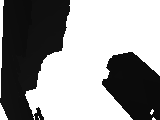

In [55]:
ids = [1]
gt_poses = [pose]
depth_image = GL.gl_render(renderer, ids, gt_poses, IDENTITY_POSE)
GL.view_depth_image(clamp.(depth_image, 0.0, 200.0))